# Dehergne repertoire analysis

> First time use: follow instructions in the [README.md](README.md) file in this directory.

## Check version of timelink

If the cell bellow updates timelink a Restart of the notebook is needed (click Restart in the bar on top of this window)

In [33]:
%%capture
%pip install --upgrade timelink

## Extensions for this notebook 
(to later migrate to timelink-py)

In [1]:

from datetime import datetime
import pandas as pd

def convert_timelink_date(tl_date: str, format='%Y%m%d') -> datetime:
    """Convert a Timelink date in the format YYYYMMDD to a Python datetime

    Args:
    tl_date: a string representing a date in the format YYYYMMDD
    format: the format used to scan the date string
    Dates can be incomplete: 1586 or 1586-03 or 158603

    Zeros can be used to register unknown values: 15860000 or 15860300

    Missing information is handled in the following way:
    * If the year is missing returns None
    * If the month is missing, returns the 2nd of July of that year (middle day of the year)
    * If the day is missing, returns the 15th of the month (middle day of the month)
            """
    # return None if tl_date is None
    if tl_date is None:
        return None
    # if tl_date is not a string, return None
    if not isinstance(tl_date, str):
        return None
    # remove dashes
    tl_date_clean = tl_date.replace('-','')
    # pad tl_date with zeros up to length 8
    tl_date_clean = tl_date_clean.ljust(8,'0')
    year, month, day = tl_date_clean[:4], tl_date_clean[4:6], tl_date_clean[6:]
    # handle the case where month is zero by setting the month to 07 and day to 02 (middle day of year)
    if year == '0000':
        return None
    elif month == '00':
        month = '07'
        day = '02'
    elif day == '00':
        day = '15'

    new_date = year + month + day
    try:
        result = datetime.strptime(new_date, format)
    except ValueError as BadDate:
        print(tl_date, tl_date_clean)
        print(BadDate)
        result=None
    return result

def calc_age_at(date_birth, today):
    """Compute the number of years between two dates"""
    # return None if either argument is None
    if date_birth is None or today is None:
        return None
    # Ensure the dates are datetime objects
    if not isinstance(date_birth, datetime):
        date_birth = convert_timelink_date(date_birth)
    if not isinstance(today, datetime):
        today = convert_timelink_date(today)

    if date_birth is None or today is None:
        return None

    # Compute the difference in years
    difference_in_years = (today - date_birth).days / 365.25
    return int(difference_in_years)

def format_timelink_date(tl_datet)->str:
    """ Format a timelink date with format YYYYMMDD and variantes to nice string"""
    # return empty string if tl_datet is None
    if tl_datet is None:
        return ''
    # return empty string if tl_datet is not a string
    if not isinstance(tl_datet, str):
        return ''
    # fill with zeros
    tl_datet = tl_datet.ljust(8,'0')
    # if tl_datet is '00000000' return empty string
    if tl_datet == '00000000':
        return ''
    # if date ends in '0000' return just the first 4 characters
    if tl_datet.endswith('0000'):
        return tl_datet[:4]
    # if date ends in '00' return the first 6 characters with an hifen between 4th and 5th characters
    if tl_datet.endswith('00'):
        return tl_datet[:4] + '-' + tl_datet[4:6]
    # Otherwise convert the date
    py_date = convert_timelink_date(tl_datet)
    if py_date is None:
        return ''
    # return date in format YYYY-MM-DD
    return py_date.strftime('%Y-%m-%d')

print("testing")
print(format_timelink_date('00000000'))
print(format_timelink_date(None))
print(format_timelink_date('1582'))
print(format_timelink_date('158203'))
print(format_timelink_date('1582-03-02'))
print(format_timelink_date('15820302'))
print(calc_age_at('1980-01-01', '2020-01-01'))
print(calc_age_at('1980-01-01', 0))

testing


1582
1582-03
1582-03-02
1582-03-02
40
None


## Initial setup

Create a TimelinkNotebook object. This will be the interface for most of your interactions with Timelink.

The first time you run this notebook, you will be prompted to install ìpykernel. This is required to run Timelink in a notebook.

Note:
* First time run takes a little time as the required Docker images are downloaded.
* Timelink will default to using sqlite as the database, see [Receipts notebook for more control](1-receipts.ipynb)


In [2]:
from timelink.notebooks import TimelinkNotebook

tlnb = TimelinkNotebook(db_type='sqlite')
tlnb.print_info(show_token=True)

Timelink version: 1.1.10
Project name: dehergne-locations
Project home: /Users/jrc/mhk-home/sources/dehergne-locations
Database type: sqlite
Database name: dehergne_locations
Kleio image: timelinkserver/kleio-server
Kleio server token: gHBzLLiV4aLEX5Zq347QT3TmzjK8ujXC
Kleio server URL: http://127.0.0.1:8088
Kleio server home: /Users/jrc/mhk-home/sources/dehergne-locations
Kleio server container: upbeat_vaughan
Kleio version requested: latest
Kleio server version: 12.4.567 (2024-02-07 13:02:03)
SQLite directory: /Users/jrc/mhk-home/sources/dehergne-locations/database/sqlite
Call print_info(show_password=True) to show the Postgres password
TimelinkNotebook(project_name=dehergne-locations, project_home=/Users/jrc/mhk-home/sources/dehergne-locations, db_type=sqlite, db_name=dehergne_locations, kleio_image=timelinkserver/kleio-server, kleio_version=latest, postgres_image=postgres, postgres_version=latest)


### Database status

Count the number of rows in each table in the database.


In [3]:
tlnb.table_row_count_df()

,table,count
0,acts,29
1,aregisters,1
2,attributes,25509
3,class_attributes,70
4,classes,14
5,entities,31666
6,geoentities,359
7,goods,0
8,kleiofiles,60
9,objects,0


## Check the status of the files

Check the import status of the translated files

* I: Imported
* E: Imported with error
* W: Imported with warnings no errors
* N: Not imported
* U: Translation updated need to reimport

In [4]:
kleio_files = tlnb.get_kleio_files()
# kleio_files.info()
kleio_files[["name","import_status","status","errors","warnings","imported","import_errors","import_warnings"]]

,name,import_status,status,errors,warnings,imported,import_errors,import_warnings
0,dehergne-0-abrev.cli,I,V,0,0,2024-05-24 04:45:39.791037,0,0
1,dehergne-a.cli,I,V,0,0,2024-05-24 04:45:54.548538,0,0
2,dehergne-b.cli,I,V,0,0,2024-05-22 01:55:38.450102,0,0
3,dehergne-c.cli,I,V,0,0,2024-05-27 02:22:56.809584,0,0
4,dehergne-d.cli,I,V,0,0,2024-05-24 04:46:31.616277,0,0
5,dehergne-e.cli,I,V,0,0,2024-05-16 06:32:10.009990,0,0
6,dehergne-f.cli,I,V,0,0,2024-05-24 04:46:48.043053,0,0
7,dehergne-g.cli,I,V,0,0,2024-05-24 04:47:03.634415,0,0
8,dehergne-h.cli,I,V,0,0,2024-05-22 01:56:41.808183,0,0
9,dehergne-i.cli,I,V,0,0,2024-05-22 01:56:44.239696,0,0


List files with import errors

In [9]:
eids = kleio_files[kleio_files["import_status"]=='E'].index
print(eids)
rpt = tlnb.get_import_rpt(kleio_files,rows=list(eids))
print(rpt)

Index([], dtype='int64')




## Update the database from Kleio sources.

Updates source translations and imports into database sources with no errors.

Only changed files since last import, or new files, will be processed.

When importing to an empty database some errors can be generated
if some files contain "xsame_as/xmesmo_que" links to other files
not yet imported.

This is solved by reimporting the files in error after the first import, so that the cross references are solved. Ensure that
that `update_from_sources` is called with ``with_import_errors=True``.

It may be necessary a third import run
to solve all cross references.

In [5]:
import logging
logging.basicConfig(level=logging.INFO)

tlnb.update_from_sources(with_import_errors=True)

## Nacionality / Nacionalidades

In [6]:
import pandas as pd
from timelink.pandas import attribute_values
# set max rows to 500
pd.set_option('display.max_rows', 500)

df_totals = attribute_values('nacionalidade',db=tlnb.db)
df_totals

,count,date_min,date_max
value,,,
Portugal,431,0,0
França,184,0,0
China,177,0,0
Itália,125,0,19730000
Espanha,43,0,0
Alemanha,36,0,0
Bélgica,23,0,0
Áustria,15,0,0
Flandres,12,0,0


### List of all with attribute "nacionalidade"

In [7]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

nacionais = entities_with_attribute(
    entity_type='person',
    show_elements=['id','name','groupname'],
    the_type='nacionalidade',
    more_attributes=['nascimento'],
    db=tlnb.db,
)
# filter groupname = 'n' (avoid "referido", "pai", "mãe")
nacionais = nacionais[nacionais.groupname=='n']
nacionais.info()

<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, deh-barnabe-de-oliveira to deh-alessandro-valignano
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id_1                 942 non-null    object
 1   name                 942 non-null    object
 2   groupname            942 non-null    object
 3   nacionalidade.type   942 non-null    object
 4   nacionalidade        942 non-null    object
 5   nacionalidade.date   942 non-null    object
 6   nacionalidade.line   942 non-null    int64 
 7   nacionalidade.level  942 non-null    int64 
 8   nacionalidade.obs    942 non-null    object
 9   nascimento           854 non-null    object
 10  nascimento.date      854 non-null    object
 11  nascimento.obs       854 non-null    object
dtypes: int64(2), object(10)
memory usage: 95.7+ KB


### Export all with attribute "nacionalidade"

In [8]:
nacionais.to_excel("paises_pessoas_n.xlsx", sheet_name='Sheet1', index=False)

### Group by nacionalidade

In [9]:
paises_totais=nacionais.groupby('nacionalidade')['id_1'].nunique().reset_index().sort_values('id_1',ascending=False)
paises_totais

,nacionalidade,id_1
19,Portugal,346
10,França,168
4,China,146
14,Itália,113
0,Alemanha,35
7,Espanha,34
3,Bélgica,22
24,Áustria,14
9,Flandres,11
2,Boémia,10


In [10]:
paises_totais.to_excel("paises_totais_n.xlsx", sheet_name='Sheet1', index=False)

### Países e locais de entrada

In [11]:

import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

nacionalidade_entrada = entities_with_attribute(
    entity_type='person',
    show_elements=['id','name','groupname'],
    the_type='nacionalidade',
    more_attributes=['nascimento', 'jesuita-entrada','jesuita-entrada-x'],
    db=tlnb.db,
)
# filter groupname = 'n' (avoid "referido", "pai", "mãe")
nacionalidade_entrada = nacionalidade_entrada[nacionalidade_entrada.groupname=='n']
nacionalidade_entrada['jesuita-entrada'] = nacionalidade_entrada['jesuita-entrada'].fillna('?')
nacionalidade_entrada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 950 entries, aloys-moriz to joao-cardoso
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_1                  950 non-null    object
 1   name                  950 non-null    object
 2   groupname             950 non-null    object
 3   nacionalidade.type    950 non-null    object
 4   nacionalidade         950 non-null    object
 5   nacionalidade.date    950 non-null    object
 6   nacionalidade.line    950 non-null    int64 
 7   nacionalidade.level   950 non-null    int64 
 8   nacionalidade.obs     950 non-null    object
 9   nascimento            862 non-null    object
 10  nascimento.date       862 non-null    object
 11  nascimento.obs        862 non-null    object
 12  jesuita-entrada       950 non-null    object
 13  jesuita-entrada.date  846 non-null    object
 14  jesuita-entrada.obs   846 non-null    object
 15  jesuita-entrada-x     0 no

In [12]:
nacionalidade_entrada.groupby(['nacionalidade','jesuita-entrada'])['id_1'].nunique()
df = nacionalidade_entrada.groupby(['nacionalidade','jesuita-entrada'])['id_1'].nunique().reset_index()
df_subtotal = df.groupby('nacionalidade')['id_1'].sum().reset_index()
df_subtotal.columns = ['nacionalidade', 'subtotal']
df = pd.merge(df, df_subtotal, on='nacionalidade')
df['perc_nacionalidade'] = df['id_1']/df['subtotal']
df.sort_values(['subtotal','nacionalidade','id_1'], ascending=[False,True,False])


,nacionalidade,jesuita-entrada,id_1,subtotal,perc_nacionalidade
99,Portugal,?,205,348,0.589080
100,Portugal,Coimbra,56,348,0.160920
103,Portugal,Lisboa,37,348,0.106322
107,Portugal,Évora,22,348,0.063218
101,Portugal,Goa,20,348,0.057471
104,Portugal,Macau,3,348,0.008621
102,Portugal,Japão,2,348,0.005747
105,Portugal,Ormuz,1,348,0.002874
106,Portugal,Portugal,1,348,0.002874
108,Portugal,Índia,1,348,0.002874


In [13]:
df = nacionalidade_entrada.groupby(['nacionalidade','jesuita-entrada'])['id_1'].nunique().reset_index()
df_subtotal = df.groupby('nacionalidade')['id_1'].sum().reset_index()
df_subtotal.columns = ['nacionalidade', 'subtotal']
df = pd.merge(df, df_subtotal, on='nacionalidade')
df['perc_nacionalidade'] = df['id_1']/df['subtotal']
df

,nacionalidade,jesuita-entrada,id_1,subtotal,perc_nacionalidade
0,Alemanha,?,15,35,0.428571
1,Alemanha,Brno,2,35,0.057143
2,Alemanha,Landsberg,7,35,0.200000
3,Alemanha,Mainz,1,35,0.028571
4,Alemanha,Polotsk,1,35,0.028571
5,Alemanha,Portugal,1,35,0.028571
6,Alemanha,Roma,3,35,0.085714
7,Alemanha,Trier,3,35,0.085714
8,Alemanha,Viena,2,35,0.057143
9,Alsácia,Landsberg,1,2,0.500000


## Jesuit Entry (jesuita-entrada)

The attribute `jesuita-entrada` records the jesuit college/noviciate
where the future missionary enrolled in the Society of Jesus.

Note that a few entries have more than one value for `jesuita-entrada`
because the person dropped out after the first enrollement and later enrolled again.

### jesuita-entrada (totals)

In [15]:
import pandas as pd
from timelink.pandas import attribute_values
# set max rows to 500
pd.set_option('display.max_rows', 500)

df_totals = attribute_values('jesuita-entrada',db=tlnb.db)
df_totals.info()
df_totals['data_inicial'] = df_totals['date_min'].apply(format_timelink_date)
df_totals['data_final'] = df_totals['date_max'].apply(format_timelink_date)
# Extract the first 4 characters of data_inicial to get the year, store in column Ano_inicial
df_totals['Ano_inicial'] = df_totals['data_inicial'].str[:4]
# Extract the first 4 characters of data_final to get the year, store in column Ano_final
df_totals['Ano_final'] = df_totals['data_final'].str[:4]
df_totals

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, ? to Índia
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   count     67 non-null     int64 
 1   date_min  67 non-null     object
 2   date_max  67 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.1+ KB


,count,date_min,date_max,data_inicial,data_final,Ano_inicial,Ano_final
value,,,,,,,
?,488,15440000,17880828,1544,1788-08-28,1544,1788
Coimbra,58,15420000,17420427,1542,1742-04-27,1542,1742
Lisboa,45,15460000,17530612,1546,1753-06-12,1546,1753
Paris,41,16300108,17590310,1630-01-08,1759-03-10,1630,1759
Roma,40,15480311,17560709,1548-03-11,1756-07-09,1548,1756
Goa,33,15480000,17360000,1548,1736,1548,1736
Évora,26,15660714,17460405,1566-07-14,1746-04-05,1566,1746
Nancy,15,16270929,17510827,1627-09-29,1751-08-27,1627,1751
Macau,14,16280000,17490201,1628,1749-02-01,1628,1749


#### Export to Excel

In [16]:
df_totals.to_excel("jesuita-entrada_totals.xlsx", sheet_name='Sheet_name_1')

### All know places of entry (todos os lugares de entrada conhecidos)

In [17]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

jesuita_entrada_full = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-entrada',
    more_attributes=['nacionalidade','nascimento'],
    db=tlnb.db,
)
jesuita_entrada_full.info()

coll = pyuca.Collator()

# we use the Collator class to sort the names and countries properly
# since Python does not sort accented characters properly
# we create two new columns with the sort keys

# first we fill the NaN values with empty strings
jesuita_entrada_full['nacionalidade'] = jesuita_entrada_full['nacionalidade'].fillna('')
jesuita_entrada_full['name'] = jesuita_entrada_full['name'].fillna('?')

# now we add two columns with sort keys
jesuita_entrada_full['nacionalidade_sort'] = jesuita_entrada_full['nacionalidade'].apply(coll.sort_key)
jesuita_entrada_full['name_sort'] = jesuita_entrada_full['name'].apply(coll.sort_key)

# save those with jesuita-entrada not equal to '?'
# entrada_known = jesuita_entrada_full['jesuita-entrada'] != '?'
only_n = jesuita_entrada_full.fillna('').groupname == 'n'
jesuita_entrada_full = jesuita_entrada_full[only_n]
cols=['jesuita-entrada','jesuita-entrada.date','name','nacionalidade','nascimento','jesuita-entrada.obs']
# jesuita_entrada_full[(only_n) & (entrada_known)].sort_values(by=['jesuita-entrada','jesuita-entrada.date','name_sort','nascimento'])[cols].head(70)
jesuita_entrada_full.sort_values(by=['jesuita-entrada.date','jesuita-entrada','name_sort','nascimento'])[cols].head(70)



<class 'pandas.core.frame.DataFrame'>
Index: 964 entries, aloys-moriz to joao-cardoso
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   964 non-null    object
 1   groupname              964 non-null    object
 2   jesuita-entrada.type   964 non-null    object
 3   jesuita-entrada        964 non-null    object
 4   jesuita-entrada.date   964 non-null    object
 5   jesuita-entrada.line   964 non-null    int64 
 6   jesuita-entrada.level  964 non-null    int64 
 7   jesuita-entrada.obs    964 non-null    object
 8   nacionalidade          921 non-null    object
 9   nacionalidade.date     921 non-null    object
 10  nacionalidade.obs      921 non-null    object
 11  nascimento             948 non-null    object
 12  nascimento.date        948 non-null    object
 13  nascimento.obs         948 non-null    object
dtypes: int64(2), object(12)
memory usage: 113.0+ KB


,jesuita-entrada,jesuita-entrada.date,name,nacionalidade,nascimento,jesuita-entrada.obs
id,,,,,,
deh-andre-fernandes-i,Ormuz,000000,André Fernandes,Portugal,Campo Maior,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-pedro-de-alcacova,Coimbra,15420000,Pedro de Alcáçova,Portugal,?,"saiu a primeira vez extra_info: {""value"": {""co..."
deh-belchior-nunes-barreto,Coimbra,15430311,Belchior Nunes Barreto,Portugal,Porto,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-belchior-miguel-carneiro-leitao,Coimbra,15430425,Belchior Miguel Carneiro Leitão,Portugal,Coimbra,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-francisco-perez,Coimbra,15440125,Francisco Pérez,Espanha,"Villanueva de Barcarrota, diocese de Badajoz","extra_info: {""date"": {""comment"": ""j\u00e1 \u00..."
deh-tiburcio-de-quadros,Coimbra,15440418,Tibúrcio de Quadros,Portugal,Santarém,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-baltasar-gago,Lisboa,15460000,Baltasar Gago,Portugal,Lisboa,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-pedro-riera,Roma,15480311,Pedro Riera,Espanha,Barcelona,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-pedro-de-alcacova,Goa,15480502,Pedro de Alcáçova,Portugal,?,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."


#### Export to Excel

In [18]:
jesuita_entrada_full[cols].to_excel("jesuitas-entrada-full.xlsx", sheet_name='Sheet_name_1')

### Analyse trends in decades

In [19]:
# extract the year from jesuita-entrada.date
jesuita_entrada_full['ano_entrada'] = jesuita_entrada_full['jesuita-entrada.date'].str[:4]
# convert 'ano_entrada' to integer
jesuita_entrada_full['ano_entrada'] = jesuita_entrada_full['ano_entrada'].astype(int)
# count ano_entrada per periods of 10 years starting from 1540
jesuita_entrada_full['periodo_entrada'] = (jesuita_entrada_full['ano_entrada'] - 1540) // 10 * 10 + 1540
# show columns jesuita-entrada.date, ano_entrada, periodo
jesuita_entrada_full[['jesuita-entrada.date','ano_entrada','periodo_entrada']].sort_values('jesuita-entrada.date').head(10)


,jesuita-entrada.date,ano_entrada,periodo_entrada
id,,,
deh-andre-fernandes-i,000000,0,0
deh-pedro-de-alcacova,15420000,1542,1540
deh-belchior-nunes-barreto,15430311,1543,1540
deh-belchior-miguel-carneiro-leitao,15430425,1543,1540
deh-francisco-perez,15440125,1544,1540
deh-tiburcio-de-quadros,15440418,1544,1540
deh-baltasar-gago,15460000,1546,1540
deh-pedro-riera,15480311,1548,1540
deh-pedro-de-alcacova,15480502,1548,1540


In [20]:
# count number of jesuitas-entrada per period
jesuita_entrada_full.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')


,periodo_entrada,name
0,0,1
1,1540,12
2,1550,24
3,1560,16
4,1570,20
5,1580,28
6,1590,24
7,1600,33
8,1610,29
9,1620,42


#### Make a graph ignoring period < 1540


In [21]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


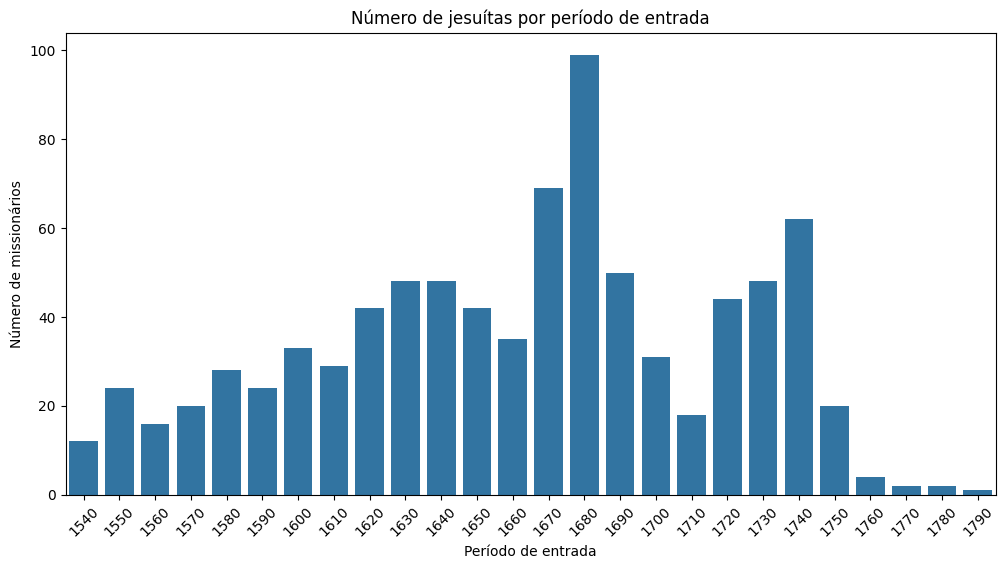

In [22]:
# make a chart of the number of jesuitas-entrada per period ignoring period < 1540
# Label the vertical axis as "Número de missionários"
# Label the horizontal axis as "Período de entrada"
import matplotlib.pyplot as plt
import seaborn as sns

# filter period >= 1540
df = jesuita_entrada_full[jesuita_entrada_full.periodo_entrada >= 1540]

# count number of jesuitas-entrada per period
df = df.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')

# create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='periodo_entrada', y='name')
plt.xticks(rotation=45)
plt.title('Número de jesuítas por período de entrada')

# Label the vertical axis
plt.ylabel('Número de missionários')

# Label the horizontal axis
plt.xlabel('Período de entrada')

plt.show()


### Place of entry "unkown" with country and place of birth

In [23]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

jesuita_entrada_full = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-entrada',
    the_value='?',
    more_attributes=['nacionalidade','nascimento'],
    db=tlnb.db,
)
# filter by those with groupname = 'n' (avoid "referido", "pai", "mãe")
jesuita_entrada_full = jesuita_entrada_full[jesuita_entrada_full.groupname=='n']

jesuita_entrada_full.info()

coll = pyuca.Collator()

# we use the Collator class to sort the names and countries properly
# since Python does not sort accented characters properly
# we create two new columns with the sort keys

# first we fill the NaN values with empty strings
jesuita_entrada_full['nacionalidade'] = jesuita_entrada_full['nacionalidade'].fillna('?')
jesuita_entrada_full['name'] = jesuita_entrada_full['name'].fillna('?')
jesuita_entrada_full['nascimento'] = jesuita_entrada_full['nascimento'].fillna('?')

# now we add two columns with sort keys
jesuita_entrada_full['nacionalidade_sort'] = jesuita_entrada_full['nacionalidade'].apply(coll.sort_key)
jesuita_entrada_full['name_sort'] = jesuita_entrada_full['name'].apply(coll.sort_key)

cols=['name','nacionalidade','nascimento','jesuita-entrada.date','jesuita-entrada','jesuita-entrada.obs']
jesuita_entrada_full[jesuita_entrada_full.groupname=='n'].sort_values(by=['nacionalidade_sort','name_sort','nascimento'])[cols].head(50)



<class 'pandas.core.frame.DataFrame'>
Index: 411 entries, deh-adam-algenler to joao-cardoso
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   411 non-null    object
 1   groupname              411 non-null    object
 2   jesuita-entrada.type   411 non-null    object
 3   jesuita-entrada        411 non-null    object
 4   jesuita-entrada.date   411 non-null    object
 5   jesuita-entrada.line   411 non-null    int64 
 6   jesuita-entrada.level  411 non-null    int64 
 7   jesuita-entrada.obs    411 non-null    object
 8   nacionalidade          408 non-null    object
 9   nacionalidade.date     408 non-null    object
 10  nacionalidade.obs      408 non-null    object
 11  nascimento             406 non-null    object
 12  nascimento.date        406 non-null    object
 13  nascimento.obs         406 non-null    object
dtypes: int64(2), object(12)
memory usage: 48.2+ KB


,name,nacionalidade,nascimento,jesuita-entrada.date,jesuita-entrada,jesuita-entrada.obs
id,,,,,,
deh-bartolome-de-roboredo,Bartolomé de Roboredo,?,?,16460000,?,"extra_info: {""date"": {""comment"": ""volta a ser ..."
deh-herman-scolt,Herman Scolt,?,?,17281228,?,
deh-jacques-barthe,Jacques Barthe,?,?,16780000,?,
deh-adam-weidenfied,Adam Weidenfied,Alemanha,Colónia,16630412,?,
deh-anton-gogeisl,Anton Gogeisl,Alemanha,"Siegenburg, Baviera, diocese de Regensburg",17200913,?,
deh-bernhard-diestel,Bernhard Diestel,Alemanha,"Wippach, Carniole",16391022,?,
deh-christian-henricus,Christian Henricus,Alemanha,?,16420000,?,
deh-christof-brack,Christof Brack,Alemanha,"Diocese de Constance, Rottenburg am Neckar",16720716,?,
deh-franz-moser,Franz Moser,Alemanha,"Mauerkirchen, dicese de Passau",17321003,?,


#### Export to Excel

In [24]:
jesuita_entrada_full[cols].to_excel("jesuitas-entrada-desc.xlsx", sheet_name='Sheet_name_1')

#### Export to text file (Portugal)

In [25]:
# Get id of interest
country_of_interest = 'Portugal'
ids = jesuita_entrada_full[jesuita_entrada_full.nacionalidade==country_of_interest].index.unique()

tlnb.db.export_as_kleio(ids,f'jesuitas-entrada-desc-{country_of_interest}.txt')

##  Missionaries by specific place of entry in the Jesuit order

Obter os missionários por lugar de entrada na ordem


### Example/Exemplo: Coimbra

Showing palce of birth, embarque (departure).

In [26]:
place_of_entry = "Coimbra"

In [29]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 1550)

jesuita_entrada_embarque = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-entrada',
    the_value=place_of_entry,
    more_attributes=['dehergne','nascimento','embarque','morte'],
    db=tlnb.db,
)

# jesuita_entrada_embarque.info()

# user only group "n"
jesuita_entrada_embarque = jesuita_entrada_embarque[jesuita_entrada_embarque.groupname=='n']

# add age at 'jesuita-entrada.date'
jesuita_entrada_embarque['age_at_entrada'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['nascimento.date'], x['jesuita-entrada.date']), axis=1)
# convert to int
jesuita_entrada_embarque['age_at_entrada'] = jesuita_entrada_embarque['age_at_entrada'].astype('Int64')

# add age at 'embarque.date'
jesuita_entrada_embarque['age_at_embarque'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['nascimento.date'], x['embarque.date']), axis=1)
# convert to int
jesuita_entrada_embarque['age_at_embarque'] = jesuita_entrada_embarque['age_at_embarque'].astype('Int64')
# years between jesuita-entrada and embarque
jesuita_entrada_embarque['entrada_to_embarque'] = jesuita_entrada_embarque['age_at_embarque'] - jesuita_entrada_embarque['age_at_entrada']

# add age at 'morte.date'
jesuita_entrada_embarque['age_at_morte'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['nascimento.date'], x['morte.date']), axis=1)
# convert to int
jesuita_entrada_embarque['age_at_morte'] = jesuita_entrada_embarque['age_at_morte'].astype('Int64')

# time in missions
jesuita_entrada_embarque['mission_time'] = jesuita_entrada_embarque.apply(lambda x: calc_age_at(x['embarque.date'], x['morte.date']), axis=1)
# convert to int
jesuita_entrada_embarque['mission_time'] = jesuita_entrada_embarque['mission_time'].astype('Int64')


# format dates
jesuita_entrada_embarque['nascimento.date.formated'] = jesuita_entrada_embarque['nascimento.date'].apply(format_timelink_date)
# create column with year (first 4 characters of 'nascimento.date.formated')
jesuita_entrada_embarque['nascimento.date.year'] = jesuita_entrada_embarque['nascimento.date.formated'].str[:4]

jesuita_entrada_embarque['jesuita-entrada.date.formated'] = jesuita_entrada_embarque['jesuita-entrada.date'].apply(format_timelink_date)
# create column with year
jesuita_entrada_embarque['jesuita-entrada.date.year'] = jesuita_entrada_embarque['jesuita-entrada.date.formated'].str[:4]
jesuita_entrada_embarque['embarque.date.formated'] = jesuita_entrada_embarque['embarque.date'].apply(format_timelink_date)
# create column with year
jesuita_entrada_embarque['embarque.date.year'] = jesuita_entrada_embarque['embarque.date.formated'].str[:4]

jesuita_entrada_embarque['morte.date.formated'] = jesuita_entrada_embarque['morte.date'].apply(format_timelink_date)
# create column with year
jesuita_entrada_embarque['morte.date.year'] = jesuita_entrada_embarque['morte.date.formated'].str[:4]

cols=['dehergne','name','nascimento.date.year',
            'jesuita-entrada.date.year','jesuita-entrada','age_at_entrada','entrada_to_embarque',
            'embarque.date.year','age_at_embarque',
            'morte.date.year','age_at_morte','mission_time','morte']
# remove lines with duplicate values for column 'dehergne'
jesuita_entrada_embarque = jesuita_entrada_embarque.sort_values(by=['jesuita-entrada.date.formated','embarque.date.formated']).drop_duplicates(subset=['dehergne'])
jesuita_entrada_embarque.info()
jesuita_entrada_embarque.sort_values(by=['jesuita-entrada.date.formated','embarque.date.formated'])[cols]


<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, deh-pedro-de-alcacova to deh-inacio-pires
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   name                           57 non-null     object
 1   groupname                      57 non-null     object
 2   jesuita-entrada.type           57 non-null     object
 3   jesuita-entrada                57 non-null     object
 4   jesuita-entrada.date           57 non-null     object
 5   jesuita-entrada.line           57 non-null     int64 
 6   jesuita-entrada.level          57 non-null     int64 
 7   jesuita-entrada.obs            57 non-null     object
 8   dehergne                       57 non-null     object
 9   dehergne.date                  57 non-null     object
 10  dehergne.obs                   57 non-null     object
 11  nascimento                     57 non-null     object
 12  nascimento.date                57 non

,dehergne,name,nascimento.date.year,jesuita-entrada.date.year,jesuita-entrada,age_at_entrada,entrada_to_embarque,embarque.date.year,age_at_embarque,morte.date.year,age_at_morte,mission_time,morte
id,,,,,,,,,,,,,
deh-pedro-de-alcacova,15,Pedro de Alcáçova,1523,1542,Coimbra,19,<NA>,,<NA>,1579,56,<NA>,?
deh-belchior-nunes-barreto,589,Belchior Nunes Barreto,1519,1543,Coimbra,23,8,1551,31,1571,52,20,Goa
deh-belchior-miguel-carneiro-leitao,143,Belchior Miguel Carneiro Leitão,1519,1543,Coimbra,23,12,1555,35,1583,64,28,Macau
deh-francisco-perez,628,Francisco Pérez,1514,1544,Coimbra,29,2,1546,31,1583,68,36,Negapatam
deh-tiburcio-de-quadros,666,Tibúrcio de Quadros,1528,1544,Coimbra,15,11,1555,26,1572,44,17,Goa
deh-goncalo-alvares,30,Gonçalo Álvares,1527,1549,Coimbra,21,19,1568,40,1573,46,5,[A caminho do Japão]
deh-cristovao-da-costa,209,Cristóvão da Costa,1529,1550,Coimbra,20,1,1551,21,1582,52,31,Macau
deh-joao-rodrigues-de-sainan,704a,João Rodrigues de Sainan,1531,1555,Coimbra,24,0,1556,24,,<NA>,<NA>,NaN
deh-pedro-martins,524,Pedro Martins,1542,1556,Coimbra,13,29,1585,42,1598,55,12,"[No mar, a caminho de Malaca]"


In [30]:
place_of_entry_ids = jesuita_entrada_embarque.index.unique()
print(len(place_of_entry_ids))

57


#### Export to Excel

In [31]:
jesuita_entrada_embarque[cols].to_excel(f"jesuita-entrada-{place_of_entry}.xlsx", sheet_name=f'jesuita_entrada_{place_of_entry}', index=True)

### Analyse trends in decades for specific place of entry

In [33]:
# Extract year from jesuita-entrada.date
jesuita_entrada_embarque['ano_entrada'] = jesuita_entrada_embarque['jesuita-entrada.date'].str[:4]
# Convert 'ano_entrada' to integer
jesuita_entrada_embarque['ano_entrada'] = jesuita_entrada_embarque['ano_entrada'].astype(int)
# Count 'ano_entrada' per periods of 10 years starting from 1540
jesuita_entrada_embarque['periodo_entrada'] = (jesuita_entrada_embarque['ano_entrada'] - 1540) // 10 * 10 + 1540
# Show columns jesuita-entrada.date, ano_entrada, periodo
jesuita_entrada_embarque[['jesuita-entrada.date','ano_entrada','periodo_entrada']].sort_values('jesuita-entrada.date').head(10)


,jesuita-entrada.date,ano_entrada,periodo_entrada
id,,,
deh-pedro-de-alcacova,15420000,1542,1540
deh-belchior-nunes-barreto,15430311,1543,1540
deh-belchior-miguel-carneiro-leitao,15430425,1543,1540
deh-francisco-perez,15440125,1544,1540
deh-tiburcio-de-quadros,15440418,1544,1540
deh-goncalo-alvares,15490101,1549,1540
deh-cristovao-da-costa,15500103,1550,1550
deh-joao-rodrigues-de-sainan,15550000,1555,1550
deh-pedro-martins,15560525,1556,1550


In [34]:
# count number of jesuitas-entrada per period
jesuita_entrada_embarque.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')

,periodo_entrada,name
0,1540,6
1,1550,3
2,1560,2
3,1570,2
4,1580,7
5,1590,4
6,1600,3
7,1610,2
8,1620,2
9,1630,2


In [35]:
# fill missing periods with 0
df_period_place_of_entry = jesuita_entrada_embarque.groupby('periodo_entrada')['name'].count().reset_index().sort_values('periodo_entrada')
df_period_place_of_entry = df_period_place_of_entry.set_index('periodo_entrada').reindex(range(1540, 1790, 10)).fillna(0).reset_index()
df_period_place_of_entry

,periodo_entrada,name
0,1540,6.0
1,1550,3.0
2,1560,2.0
3,1570,2.0
4,1580,7.0
5,1590,4.0
6,1600,3.0
7,1610,2.0
8,1620,2.0
9,1630,2.0


#### Make a graph

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


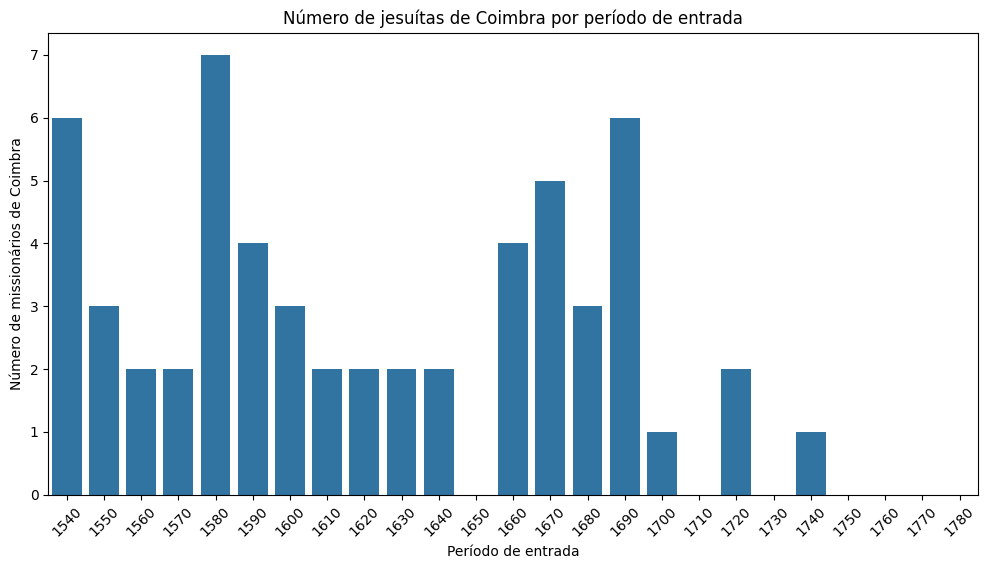

In [36]:
# make a chart of the number of jesuitas-entrada per period ignoring period < 1540
# Label the vertical axis as "Número de missionários de Coimbra"
# Label the horizontal axis as "Período de entrada"
import matplotlib.pyplot as plt
import seaborn as sns

# create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_period_place_of_entry, x='periodo_entrada', y='name')
plt.xticks(rotation=45)
plt.title(f'Número de jesuítas de Coimbra por período de entrada')

# Label the vertical axis
plt.ylabel('Número de missionários de Coimbra')

# Label the horizontal axis
plt.xlabel('Período de entrada')

plt.show()

#### Export records to text file

In [37]:
tlnb.db.export_as_kleio(jesuita_entrada_embarque.index.unique(), f"jesuita-entrada-{place_of_entry}.txt")

### Export those with place of entry originally unkown by Dehergne

Added with extra sources

Check those whoose place of entry was originally undertermined in Dehergne.

Those have the notation '%?' in the transcription and in the database, e.g.:

      ls$jesuita-entrada/Coimbra/15600314/obs=
            """
            extra_info: {
                "date": {"comment": "ou 15600325 ou Coimbra, 25-03-1560 MMHM"}, 
                "value": {"comment": "Domingues & O Neil, IV: 2645. MMHM:p.226", 
                           "original": "?"}}
  """

In [38]:
# List rows if '"original": "?"' is in column 'jesuita_entrada.obs'
cols_2 = ['name','jesuita-entrada','jesuita-entrada.date','jesuita-entrada.obs']
place_of_entry_extra = jesuita_entrada_embarque[jesuita_entrada_embarque['jesuita-entrada.obs'].str.contains('"original": "?"', na=False)][cols_2]
place_of_entry_extra_ids = place_of_entry_extra.index.unique()
print("jesuita-entrada through extra info:",len(place_of_entry_extra_ids))
place_of_entry_extra

jesuita-entrada through extra info: 15


,name,jesuita-entrada,jesuita-entrada.date,jesuita-entrada.obs
id,,,,
deh-lourenco-mexia,Lourenço Mexia,Coimbra,15600314,"extra_info: {""date"": {""comment"": ""ou 15600325 ..."
deh-manuel-gaspar,Manuel Gaspar,Coimbra,15750926,"extra_info: {""value"": {""comment"": ""Schutte, Mo..."
deh-joao-da-rocha,João da Rocha,Coimbra,15830000,"Corrigido: local de entrada extra_info: {""valu..."
deh-mateus-de-couros,Mateus de Couros,Coimbra,15831222,"extra_info: {""value"": {""comment"": ""MMHM:p.94 (..."
deh-andre-palmeiro,André Palmeiro,Coimbra,15840114,"extra_info: {""value"": {""comment"": ""Segundo Dom..."
deh-manuel-dias-o-novo,"Manuel Dias, o Novo",Coimbra,15930202,"extra_info: {""value"": {""comment"": ""Segungo Dom..."
deh-simao-da-cunha,Simão da Cunha,Coimbra,16060113,"extra_info: {""value"": {""comment"": ""Dehergne n\..."
deh-antonio-de-gouvea,António de Gouvea,Coimbra,16080502,"extra_info: {""date"": {""comment"": ""ou 16090502""..."
deh-gaspar-do-amaral,Gaspar do Amaral,Coimbra,16080601,"extra_info: {""date"": {""comment"": ""MMHM:p.8""}, ..."


#### Save to Excel

In [39]:
place_of_entry_extra.to_excel(f"jesuita-entrada-{place_of_entry}-extra_info.xlsx", sheet_name=f'jesuita_entrada_{place_of_entry}_extra', index=True)

Make a list

In [43]:
names_list = list(place_of_entry_extra.name)

# Join the list into a comma-separated string
comma_separated_names = ', '.join(sorted(names_list))

print(comma_separated_names)
names_list

Adriano Pestana, André Ferrão, André Palmeiro, António de Gouvea, Francisco Furtado, Gabriel de Magalhães, Gaspar do Amaral, João da Rocha, Lourenço Mexia, Manuel Dias, o Novo, Manuel Gaspar, Mateus de Couros, Matias da Maia, Sebastião da Maia, Simão da Cunha


['Lourenço Mexia',
 'Manuel Gaspar',
 'João da Rocha',
 'Mateus de Couros',
 'André Palmeiro',
 'Manuel Dias, o Novo',
 'Simão da Cunha',
 'António de Gouvea',
 'Gaspar do Amaral',
 'Francisco Furtado',
 'Sebastião da Maia',
 'Gabriel de Magalhães',
 'Matias da Maia',
 'Adriano Pestana',
 'André Ferrão']

#### export to text file

In [44]:

tlnb.db.export_as_kleio(place_of_entry_extra_ids, f"jesuita-entrada-{place_of_entry}-extra_info.txt")

#### If unkown check place of entry in the birthplace 

Check for place of interest in the birth place 
of those with no record of place of entry

In [45]:
# filter dataframe jesuita_entrada_desc for rows with place_of_entry in in column 'nascimento'
maybe = jesuita_entrada_full[jesuita_entrada_full['nascimento'].str.contains(place_of_entry, na=False)].index.unique()
cols=['name','nacionalidade','nascimento','jesuita-entrada.date','jesuita-entrada','jesuita-entrada.obs']
maybe_place_of_entry = jesuita_entrada_full.loc[maybe]
maybe_place_of_entry.info()
maybe_place_of_entry.sort_values(by=['jesuita-entrada.date'])[cols]

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, deh-antonio-lopes-senior to deh-xavier-duarte
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   29 non-null     object
 1   groupname              29 non-null     object
 2   jesuita-entrada.type   29 non-null     object
 3   jesuita-entrada        29 non-null     object
 4   jesuita-entrada.date   29 non-null     object
 5   jesuita-entrada.line   29 non-null     int64 
 6   jesuita-entrada.level  29 non-null     int64 
 7   jesuita-entrada.obs    29 non-null     object
 8   nacionalidade          29 non-null     object
 9   nacionalidade.date     29 non-null     object
 10  nacionalidade.obs      29 non-null     object
 11  nascimento             29 non-null     object
 12  nascimento.date        29 non-null     object
 13  nascimento.obs         29 non-null     object
 14  nacionalidade_sort     29 non-null     obje

,name,nacionalidade,nascimento,jesuita-entrada.date,jesuita-entrada,jesuita-entrada.obs
id,,,,,,
deh-inacio-lobo,Inácio Lobo,Portugal,Coimbra,16240000,?,
deh-jose-estevao-de-almeida,José Estêvão de Almeida,Portugal,"Esgueira, diocese de Coimbra",16280000,?,
deh-antonio-lopes-senior,"António Lopes, sénior",Portugal,"Taveiro, diocese de Coimbra",16310000,?,
deh-inacio-lobo,Inácio Lobo,Portugal,Coimbra,16350000,?,
deh-luis-pinheiro,Luís Pinheiro,Portugal,"Esgueira, diocese de Coimbra",16370000,?,
deh-luis-pinheiro,Luís Pinheiro,Portugal,"Esgueira, diocese de Coimbra",16450000,?,
deh-joao-couceiro,João Couceiro,Portugal,"Tentúgal, diocese de Coimbra",16490000,?,
deh-jose-soares,José Soares,Portugal,"Santa Comba Dão, diocese de Coimbra",16730300,?,"extra_info: {""date"": {""comment"": ""a 15, 23 ou ..."
deh-antonio-simoes-i,António Simões,Portugal,"Rio de Galinhas, diocese de Coimbra",16780000,?,


In [46]:
print("Number of unique ids:", maybe_place_of_entry.index.nunique())

Number of unique ids: 27


Export maybe place of entry candidates

In [47]:
maybe_place_of_entry[cols].to_excel(f"jesuita-entrada-maybe-{place_of_entry}.xlsx", sheet_name=f'jesuita_entrada_maybe_{place_of_entry}', index=True)

Export as text file

In [48]:
tlnb.db.export_as_kleio(maybe_place_of_entry.index.unique(), f"jesuita-entrada-maybe-{place_of_entry}.txt")

 ### Roles and tasks of missionaries from specific place of entry

In [43]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 1550)

ids = place_of_entry_ids

roles_tasks = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname',],
    the_type=['jesuita-cargo','jesuita-tarefa'],
    column_name='cargos_tarefas',
    more_attributes=[],
    filter_by=ids,
    db=tlnb.db,
)

roles_tasks.info()
cols=['name','groupname','cargos_tarefas','cargos_tarefas.date']
roles_tasks[cols].sort_values(['name','cargos_tarefas','cargos_tarefas.date','name']).head(50)


<class 'pandas.core.frame.DataFrame'>
Index: 175 entries, deh-antonio-de-andrade to deh-manuel-ribeiro-senior
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  175 non-null    object 
 1   groupname             175 non-null    object 
 2   cargos_tarefas.type   158 non-null    object 
 3   cargos_tarefas        158 non-null    object 
 4   cargos_tarefas.date   158 non-null    object 
 5   cargos_tarefas.line   158 non-null    float64
 6   cargos_tarefas.level  158 non-null    float64
 7   cargos_tarefas.obs    158 non-null    object 
dtypes: float64(2), object(6)
memory usage: 12.3+ KB


,name,groupname,cargos_tarefas,cargos_tarefas.date
id,,,,
deh-adriano-pestana,Adriano Pestana,n,NaN,NaN
deh-afonso-aires,Afonso Aires,n,NaN,NaN
deh-andre-carneiro,André Carneiro,n,NaN,NaN
deh-andre-ferrao,André Ferrão,n,Assina a carta anual da vice-província da Chin...,16560000
deh-andre-palmeiro,André Palmeiro,n,Preside a conferência de Kiating e monstra-se ...,16270000
deh-andre-palmeiro,André Palmeiro,n,Visitador das províncias de Goa e do Malabar,16210000
deh-andre-palmeiro,André Palmeiro,n,Visitador das províncias de Goa e do Malabar,16260000
deh-andre-palmeiro,André Palmeiro,n,Visitador das províncias do Malabar,16180000
deh-andre-palmeiro,André Palmeiro,n,Visitador das províncias do Malabar,16210000


#### Export to Excel

In [44]:
roles_tasks[cols].to_excel(f"jesuita-entrada-{place_of_entry}-cargos_tarefas.xlsx", sheet_name='cargos_tarefas', index=True)

### Joint biography of entry in Place of interest

In [ ]:
from timelink.pandas import display_group_attributes, group_attributes

ids = place_of_entry_ids

no_show=['jesuita-entrada.level','jesuita-entrada.line','dehergne','estadia@wikidata','jesuita-estatuto',
          'nome','nacionalidade','nascimento@wikidata','nome-chines','titulo','jesuita-entrada@wikidata',
          'jesuita-votos-local@wikidata',
          'wicky','wicky-viagem']

show=['jesuita-entrada','embarque','partida','chegada','estadia','cargo','jesuita-cargo','jesuita-tarefa','morte']
display_group_attributes(ids,
                    entity_type='person',
                    header_elements=['name'],
                    sort_header='jesuita-entrada.date',
                    header_attributes=['jesuita-entrada'],
                    include_attributes=show,
                    exclude_attributes=no_show,
                    sort_attributes=['the_date','the_type','the_value'],
                    db=tlnb.db,
                    category='id',
                    cmap_name='Pastel2'
                    )

## Places of stay / "estadias"

Places of stay: merges different attributes that have locations.





Can filter by places of entry using
the ids saved above in `place_of_entry_ids`

In [55]:
import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 1550)

ids = place_of_entry_ids

places_of_stay = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname','the_line','the_order'],
    the_type=['jesuita-entrada','partida','chegada','estadia','estadia-x',
              'jesuita-votos-local','jesuita-ordenacao-padre','morte'],
    column_name='place',
    more_attributes=[],
    filter_by=ids,
    db=tlnb.db,
)



# this sequence replaces missing dates with the value of the previous date
# followed by ">". This allows to use the information that although the date
# is unkown it has happened after a certain date
# we need the id in a column to group by it (it is currently in the index)
# TODO: maybe an option in entities_with_attribute and compute intervals using
#       post quem and ante quem dates. See https://github.com/time-link/timelink-kleio/issues/1
places_of_stay['id_col'] = places_of_stay.index
# create a copy of the date column to replace the '0' values with NaN
places_of_stay['place.date_inferred'] = places_of_stay['place.date'].replace('0', pd.NA)
# order by id and line to have the missing date values filled with the previous date
places_of_stay = places_of_stay.sort_values(by=['id_col', 'place.line'])
# use ffill to fill the missing values with the previous value
places_of_stay['place.date_inferred'] = places_of_stay.groupby(['id_col'])['place.date_inferred'].fillna(method='ffill')
# create a column to flag the inferred dates
places_of_stay['place.date_is_inferred'] = places_of_stay['place.date_inferred'] != places_of_stay['place.date']
# reset index
places_of_stay.reset_index(inplace=True)
# if data_is_inferred set date_inferred to date_inferrred+">"
places_of_stay.loc[places_of_stay['place.date_is_inferred'], 'place.date_inferred'] = places_of_stay['place.date_inferred'] + '>'
# set missing value to ''
places_of_stay['place.date_inferred'].fillna('', inplace=True)
# restore index
places_of_stay.index = places_of_stay['id_col']

places_of_stay.info()
# show results
show_only=150
cols=['groupname','name','place.type','place','place.date_inferred','place.date_is_inferred','place.line','place.obs']
places_of_stay[places_of_stay.groupname=='n'][cols].sort_values(by=['place','place.date_inferred']).head(show_only)



<class 'pandas.core.frame.DataFrame'>
Index: 479 entries, deh-adriano-pestana to deh-tome-pereira
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      479 non-null    object
 1   name                    479 non-null    object
 2   groupname               479 non-null    object
 3   the_line                479 non-null    int64 
 4   the_order               479 non-null    int64 
 5   place.type              479 non-null    object
 6   place                   479 non-null    object
 7   place.date              479 non-null    object
 8   place.line              479 non-null    int64 
 9   place.level             479 non-null    int64 
 10  place.obs               479 non-null    object
 11  id_col                  479 non-null    object
 12  place.date_inferred     479 non-null    object
 13  place.date_is_inferred  479 non-null    bool  
dtypes: bool(1), int64(4), object(9)


,groupname,name,place.type,place,place.date_inferred,place.date_is_inferred,place.line,place.obs
id_col,,,,,,,,
deh-belchior-miguel-carneiro-leitao,n,Belchior Miguel Carneiro Leitão,jesuita-ordenacao-padre,?,15510000,False,503,"extra_info: {""date"": {""comment"": ""antes de""}}"
deh-belchior-nunes-barreto,n,Belchior Nunes Barreto,jesuita-ordenacao-padre,?,15510000,False,392,"extra_info: {""date"": {""comment"": ""antes de""}}"
deh-tiburcio-de-quadros,n,Tibúrcio de Quadros,jesuita-ordenacao-padre,?,15530000,False,26,"extra_info: {""date"": {""comment"": ""antes de""}}"
deh-lourenco-mexia,n,Lourenço Mexia,jesuita-ordenacao-padre,?,15660000,False,1508,"extra_info: {""date"": {""comment"": ""pouco antes""}}"
deh-pedro-de-alcacova,n,Pedro de Alcáçova,morte,?,15790000,False,301,
deh-joao-rodrigues-girao,n,João Rodrigues Girão,jesuita-ordenacao-padre,?,15850000,False,1140,"extra_info: {""date"": {""comment"": ""cerca de""}}"
deh-joao-da-rocha,n,João da Rocha,jesuita-ordenacao-padre,?,15920000,False,773,"extra_info: {""date"": {""comment"": ""cerca de""}}"
deh-diogo-correia-valente,n,Diogo Correia Valente,jesuita-ordenacao-padre,?,16000000,False,1858,
deh-gaspar-ferreira,n,Gaspar Ferreira,jesuita-ordenacao-padre,?,16070000,False,694,"extra_info: {""date"": {""comment"": ""cerca de""}}"


### Save to Excel

In [61]:
places_of_stay[ ~(places_of_stay['place.obs'].str.contains('wikidata', na=False))][cols].sort_values(by=['place','place.date_inferred']).to_excel(f"jseuita_entrada_{place_of_entry}_places_of_stay_no_wikidata.xlsx", sheet_name='no_wikidata', index=True)

### Frequency of places / Frequência dos lugares

In [57]:
places_of_stay.info()

<class 'pandas.core.frame.DataFrame'>
Index: 479 entries, deh-adriano-pestana to deh-tome-pereira
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      479 non-null    object
 1   name                    479 non-null    object
 2   groupname               479 non-null    object
 3   the_line                479 non-null    int64 
 4   the_order               479 non-null    int64 
 5   place.type              479 non-null    object
 6   place                   479 non-null    object
 7   place.date              479 non-null    object
 8   place.line              479 non-null    int64 
 9   place.level             479 non-null    int64 
 10  place.obs               479 non-null    object
 11  id_col                  479 non-null    object
 12  place.date_inferred     479 non-null    object
 13  place.date_is_inferred  479 non-null    bool  
dtypes: bool(1), int64(4), object(9)


In [58]:
# create a column with the index values which are the id numbers

col = 'place' # subotal by this column

# Use pandas groupby and specify unique value count for id
df_totals = places_of_stay.groupby(col).agg({'id':'nunique',
                                                'place.date_inferred':'min',
                                                'place.date':'max'})

df_totals.sort_values('id',ascending= False).head(30)

,id,place.date_inferred,place.date
place,,,
Coimbra,57,15420000,17530000
Macau,38,15630829,17480000
?,23,15510000,17760000
Goa,23,000000,17420908
Pequim,14,16040200,17510420
Cantão,10,15550000,17210524
China,9,16100000,17420000
Japão,9,15520000,16320712
Hangchow,9,16120000,16920000


### Place of stay "Coimbra"

In [59]:
place='Coimbra'

In [60]:
places_of_stay[places_of_stay.place==place][cols].sort_values(by=['place.date_inferred']).head(show_only)


,groupname,name,place.type,place,place.date_inferred,place.date_is_inferred,place.line,place.obs
id_col,,,,,,,,
deh-pedro-de-alcacova,n,Pedro de Alcáçova,jesuita-entrada,Coimbra,15420000,False,294,"saiu a primeira vez extra_info: {""value"": {""co..."
deh-belchior-nunes-barreto,n,Belchior Nunes Barreto,jesuita-entrada,Coimbra,15430311,False,372,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-belchior-miguel-carneiro-leitao,n,Belchior Miguel Carneiro Leitão,jesuita-entrada,Coimbra,15430425,False,487,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-francisco-perez,n,Francisco Pérez,jesuita-entrada,Coimbra,15440125,False,851,"extra_info: {""date"": {""comment"": ""j\u00e1 \u00..."
deh-tiburcio-de-quadros,n,Tibúrcio de Quadros,jesuita-entrada,Coimbra,15440418,False,14,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-goncalo-alvares,n,Gonçalo Álvares,jesuita-entrada,Coimbra,15490101,False,688,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-cristovao-da-costa,n,Cristóvão da Costa,jesuita-entrada,Coimbra,15500103,False,2105,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-joao-rodrigues-de-sainan,n,João Rodrigues de Sainan,jesuita-entrada,Coimbra,15550000,False,1091,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-pedro-martins,n,Pedro Martins,jesuita-entrada,Coimbra,15560525,False,791,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."


## Vows / Votos

In [167]:
import pyuca  # to sort accented characters properly

import pandas as pd
from timelink.pandas import entities_with_attribute
# show 500 rows
pd.set_option('display.max_rows', 550)

jesuita_entrada_full = entities_with_attribute(
    entity_type='person',
    show_elements=['name','groupname'],
    the_type='jesuita-votos',
    more_attributes=['jesuita-votos-local','nascimento', 'jesuita-entrada'],
    db=tlnb.db,
)
jesuita_entrada_full.info()

coll = pyuca.Collator()

# we use the Collator class to sort the names and countries properly
# since Python does not sort accented characters properly
# we create two new columns with the sort keys

# first we fill the NaN values with empty strings
jesuita_entrada_full['jesuita-votos-local'] = jesuita_entrada_full['jesuita-votos-local'].fillna('?')
jesuita_entrada_full['jesuita-votos-local'] = jesuita_entrada_full['jesuita-votos-local'].fillna('?')

# now we add two columns with sort keys
jesuita_entrada_full['jesuita-votos-loc-sort'] = jesuita_entrada_full['jesuita-votos-local'].apply(coll.sort_key)
jesuita_entrada_full['name_sort'] = jesuita_entrada_full['name'].apply(coll.sort_key)

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, aloys-moriz to joao-cardoso
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   name                      629 non-null    object
 1   groupname                 629 non-null    object
 2   jesuita-votos.type        629 non-null    object
 3   jesuita-votos             629 non-null    object
 4   jesuita-votos.date        629 non-null    object
 5   jesuita-votos.line        629 non-null    int64 
 6   jesuita-votos.level       629 non-null    int64 
 7   jesuita-votos.obs         629 non-null    object
 8   jesuita-votos-local       529 non-null    object
 9   jesuita-votos-local.date  529 non-null    object
 10  jesuita-votos-local.obs   529 non-null    object
 11  nascimento                604 non-null    object
 12  nascimento.date           604 non-null    object
 13  nascimento.obs            604 non-null    object
 14  jesuita-entr

In [ ]:
# filter dataframe with rows with index in place_of_entry_ids


In [170]:

df = jesuita_entrada_full[jesuita_entrada_full.index.isin(place_of_entry_ids)].copy()
# calculate age at date "jesuita-votos.date" considering "nascimento.date" as date of birth
# and using the function convert_timelink_date to convert the Timelink date to a Python datetime
df['nascimento.date_2'] = df['nascimento.date'].fillna('0').apply(convert_timelink_date)
df['jesuita-votos.date_2'] = df['jesuita-votos.date'].fillna('0').apply(convert_timelink_date)
# calculate diference in years between the two dates
df['age_at_votos'] = df.apply(lambda row: calc_age_at(row['nascimento.date_2'], row['jesuita-votos.date_2']), axis=1)
df['age_at_votos'] = df['age_at_votos'].fillna(0).astype(int)
df[['nascimento.date','jesuita-votos.date','jesuita-votos','age_at_votos']].head(50)


,nascimento.date,jesuita-votos.date,jesuita-votos,age_at_votos
id,,,,
deh-andre-carneiro,16500000,16821208,4V,32
deh-andre-ferrao,16250000,16590116,4V,33
deh-andre-palmeiro,15690000,16030727,4V,34
deh-antao-dantas,16741102,17110815,4V,36
deh-antonio-da-silva,16540113,16870815,4V,33
deh-antonio-de-andrade,15800000,16121014,4V,32
deh-antonio-de-gouvea,15920000,16460714,4V,54
deh-antonio-de-gouvea,15920000,16460714,4V,54
deh-antonio-de-magalhaes,16770000,17110202,4V,33


## Other

### Wikidata coordinates

In [ ]:
%pip install pywikibot

In [14]:
import pywikibot

wikidata_id = 'Q171943'
site = pywikibot.Site("wikidata", "wikidata")
repo = site.data_repository()
item = pywikibot.ItemPage(repo, wikidata_id)
item_dict = item.get()
chinese_label = item_dict['labels']['zh']
english_label = item_dict['labels']['en']
# fetch also the Portuguese label if it exists
portuguese_label = item_dict['labels'].get('pt', None)
# fetch the english description if it exists
english_description = item_dict['descriptions'].get('en', None)
print(chinese_label,english_label, f"({english_description})", portuguese_label)
coord = item_dict['claims']['P625'][0].getTarget()
print(coord.lat, coord.lon)

南昌市 Nanchang (capital of Jiangxi province, China) Nanchang
28.684167 115.887222




###  Remover colunas sem valores

---



###  Remove empty columns

In [53]:
jesuita_entrada_embarque.dropna(how='all', axis=1, inplace=True)
jesuita_entrada_embarque.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181 entries, deh-afonso-aires to deh-tome-pereira
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  181 non-null    object
 1   groupname             181 non-null    object
 2   jesuita-entrada       181 non-null    object
 3   jesuita-entrada.date  181 non-null    object
 4   jesuita-entrada.obs   181 non-null    object
 5   nascimento            181 non-null    object
 6   nascimento.date       181 non-null    object
 7   nascimento.obs        181 non-null    object
 8   estadia               176 non-null    object
 9   estadia.date          176 non-null    object
 10  estadia.obs           176 non-null    object
 11  morte                 172 non-null    object
 12  morte.date            172 non-null    object
 13  morte.obs             172 non-null    object
dtypes: object(14)
memory usage: 21.2+ KB


In [54]:
jesuita_entrada_embarque.head(5)

,name,groupname,jesuita-entrada,jesuita-entrada.date,jesuita-entrada.obs,nascimento,nascimento.date,nascimento.obs,estadia,estadia.date,estadia.obs,morte,morte.date,morte.obs
id,,,,,,,,,,,,,,
deh-afonso-aires,Afonso Aires,n,Coimbra,16490000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Santarém,16300000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",NaN,NaN,NaN,"[No mar, depois do Cabo da Boa Esperança]",16570000,
deh-andre-carneiro,André Carneiro,n,Coimbra,16640325,"extra_info: {""date"": {""comment"": ""ou 16630325""...",Porto,16500000,"extra_info: {""date"": {""comment"": ""ou 16480923""...","Chinchinim, Goa",17050000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Goa,17090612,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-antao-dantas,Antão Dantas,n,Coimbra,16930310,"extra_info: {""date"": {""comment"": ""ou 16931016 ...",Porto,16741102,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Macau,17050000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Goa,17210522,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-antao-dantas,Antão Dantas,n,Coimbra,16930310,"extra_info: {""date"": {""comment"": ""ou 16931016 ...",Porto,16741102,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Manila,17070000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Goa,17210522,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-antao-dantas,Antão Dantas,n,Coimbra,16930310,"extra_info: {""date"": {""comment"": ""ou 16931016 ...",Porto,16741102,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Macau,17120000,"extra_info: {""value"": {""comment"": ""@wikidata:Q...",Goa,17210522,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."



## Contagens

---

## Counting



###  Contagem de atributos a partir de uma tabela em memória

---

###  Count attributes from an existing dataframe



In [20]:
# create a column with the index values which are the id numbers
jesuita_entrada_embarque['id'] = jesuita_entrada_embarque.index.values

col = 'estadia' # subotal by this column

# Use pandas groupby and specify unique value count for id
df_totals = jesuita_entrada_embarque.groupby(col).agg({'id':'nunique',
                                                  'estadia.date':'min',
                                                  'estadia.date':'max'})

df_totals.sort_values('id',ascending= False).head(30)

,id,estadia.date
estadia,,
Macau,19,17480000
Goa,12,17270000
Cantão,8,17190000
Pequim,6,17440000
Índia,5,17220000
Nanquim,4,17140000
Malaca,4,15720000
Sião,4,17450000
China,3,17340000



### Contagens na base de dados

Quando o atributo tem muitos valores e não é necessário
ter todas as pessoas em memória: contagem feita na base de dados

---

### Counting directly in the database
When there are many values and it is not
necessary to have all the people in memory:
count directly in the database.




In [21]:
from timelink.pandas import attribute_values

df_totals = attribute_values('jesuita-entrada',db=tlnb.db)


In [22]:
df_totals.head(10)


,count,date_min,date_max
value,,,
?,512,0,17880828
Coimbra,43,15420000,17420427
Paris,42,15340815,17590310
Lisboa,39,15460000,17521123
Roma,32,15400927,17560709
Goa,30,15480000,17360000
Évora,22,15660714,17460405
Nancy,15,16270929,17510827
Macau,14,16280000,17490201


#### Filtrar por datas

---

#### Filter by dates



In [29]:
df_totals = attribute_values('grau',dates_between=('1535','1600'),db=tlnb.db)

In [30]:
df_totals.head(10)

,count,date_min,date_max
value,,,
Bacharel,9,1554-07-19,1593-06-09
Formatura,6,1574-07-24,1593-05-12
Bacharel em Artes,3,1574-03-14,1588-03-12
Licenciado,3,1574-06-03,1597-05-06
Doutor,2,1560-12-22,1589-10-27
Licenciado em Artes,2,1574-05-15,1589-01-13


## Visualizar registos / View records





### Visualizar uma pessoa / View a person


#### Atributos de uma pessoa numa tabela, uma linha por attributo

---

#### Person attributes in a dataframe, one line per attribute

In [15]:
import pandas as pd
from timelink.pandas import group_attributes as person_attributes

pd.set_option('display.max_rows',1000)

id = 'deh-abraham-le-royer'
pdf = person_attributes([id],db=tlnb.db)  # note id in a list
pdf[['the_date','the_type','the_value','attr_obs']].sort_values(['the_date','the_type'])

,the_date,the_type,the_value,attr_obs
id,,,,
deh-abraham-le-royer,0,dehergne,465,"Le Royer, Abraham (franç.) P. 465 N. 9 févr. 1..."
deh-abraham-le-royer,0,estadia,Kwangtung,"extra_info: {""value"": {""comment"": ""?""}}"
deh-abraham-le-royer,0,jesuita-estatuto,Padre,
deh-abraham-le-royer,0,nacionalidade,França,
deh-abraham-le-royer,16460209,nascimento,"Domfront, diocese de Mans","extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-abraham-le-royer,16460209,nascimento@wikidata,https://www.wikidata.org/wiki/Q659992,"extra_info: {""value"": {""original"": ""Domfront, ..."
deh-abraham-le-royer,16650831,jesuita-entrada,Paris,"extra_info: {""value"": {""comment"": ""@wikidata:Q..."
deh-abraham-le-royer,16650831,jesuita-entrada@wikidata,https://www.wikidata.org/wiki/Q90,"extra_info: {""value"": {""original"": ""Paris""}}"
deh-abraham-le-royer,16770000,jesuita-ordenacao-padre,?,


In [16]:
p = tlnb.db.get_person(id)
print(p.to_kleio())

n$Adriano Pestana/m/id=deh-adriano-pestana
  ls$nacionalidade/Portugal/0
  ls$jesuita-estatuto/Padre/0
  ls$nascimento@/"https://www.wikidata.org/wiki/Q209036"/16170000
  ls$nascimento/Ilha de S. Miguel, Açores/16170000
  ls$jesuita-entrada/?/16350000
  ls$embarque/?/16430330
  ls$wicky/912/16430330
  ls$wicky-viagem/77/16430330
  ls$estadia@/"https://www.wikidata.org/wiki/Q14773"/16480000
  ls$estadia/Macau (colégio)/16480000
  ls$estadia@/"https://www.wikidata.org/wiki/Q14773"/16540000
  ls$estadia/Macau (colégio)/16540000
  ls$dehergne/631/0/obs="""
      Pestana, Adriano (port.) P. 631 N. Ile S. Miguel, 1617 -E. 1635 (Lus. 44 II, 580). Emb. 30 mars 1643 (W 912)., en 1648 au collège de Macao, mais « pertinet ad vice-provinciam Sinensem » (JS 25, 148), de même en 1654 (JS 25, 161v). M. (n'est plus au catal. de 1660, JS 134, 344)., omis par HS 48.
  """


#### Atributos de uma pessoa numa tabela, attributos em colunas

---

#### Person attributes in a dataframe, attributes in columns

In [39]:
# Get list of people with with a certain value in a specific attribute

id = '316297'  # João Pedro Ribeiro
# id = '234295'  # Alexandre Metelo de Sousa
df = entities_with_attribute(
                    entity_type='person',
                    the_type='uc.entrada',  # we need a base attribute
                    more_info=['name'],
                    more_cols=['instituta','faculdade'],
                    db=tlnb.db,
                    sql_echo=False)
view_cols = ['name','faculdade','faculdade.date','faculdade.obs']
df.info()
df[view_cols].sort_values('faculdade.date')

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 140337 to 269364
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             503 non-null    object
 1   uc.entrada       503 non-null    object
 2   uc.entrada.date  503 non-null    object
 3   uc.entrada.obs   0 non-null      object
 4   instituta        205 non-null    object
 5   instituta.date   205 non-null    object
 6   instituta.obs    205 non-null    object
 7   faculdade        447 non-null    object
 8   faculdade.date   447 non-null    object
 9   faculdade.obs    29 non-null     object
dtypes: object(10)
memory usage: 43.2+ KB


,name,faculdade,faculdade.date,faculdade.obs
id,,,,
140345,Jorge Abenajado,Medicina,1537-12-17,None
140669,Diogo de Abreu,Leis,1538-05-07,None
140347,Adrião de Aboim,Leis,1539-12-07,None
140708,Filipe de Abreu,Cânones,1548-06-23,None
140541,António de Abreu,Cânones,1551-10-00,None
140358,João de Aboim,Cânones,1551-10-01,None
140670,Diogo de Abreu,Leis,1552-07-00,None
140695,Duarte de Abreu,Cânones,1566-01-20,None
140349,António de Aboim,Cânones,1566-12-20,None


#### Examinar potenciais duplicados

---

#### Examine potentital duplicates

In [15]:
from timelink.pandas import display_group_attributes
pd.set_option('display.max_rows',250)

no_show=['código-de-referência','data-do-registo','url','faculdade.ano','naturalidade.ano',
         'matricula-faculdade.ano','nome-apelido','nome-primeiro','nome-geografico.ano',
         'grau.ano','matricula-outra.ano','nome-geografico','instituta.ano']

dup_ids = ['234295','234710',]  # Alexandre Metelo de

display_group_attributes(dup_ids,
                             header_cols=['uc-entrada','naturalidade','faculdade','nome-pai'],
                             exclude_attributes=no_show,
                             sort_attributes=['date','type','value'],
                             cmap_name='Pastel1')

,id,uc-entrada,naturalidade,faculdade,nome-pai
0,234295,1704-11-07,Marialva,Cânones,nan
1,234710,1705-10-24,Marialva,Matemática,Manuel Cardoso Metelo


,date,id,type,value,attr_obs
0,1704-11-07,234295,faculdade,Cânones,Cânones
1,1704-11-07,234295,instituta,1704-11-07,07.11.1704 1704-11-07
2,1704-11-07,234295,naturalidade,Marialva,None
3,1704-11-07,234295,nome,Alexandre Metelo de Sousa,None
4,1704-11-07,234295,uc-entrada,1704-11-07,None
5,1704-11-07,234295,uc-entrada.ano,1704,None
6,1705-10-24,234710,faculdade,Matemática,Matemática
7,1705-10-24,234295,matricula-faculdade,Cânones,24.10.1705
8,1705-10-24,234710,matricula-faculdade,Matemática,24.10.1705
9,1705-10-24,234710,naturalidade,Marialva,None
